In [1]:
%load_ext autoreload
%autoreload 2

# Baseline Completo - Análisis Exhaustivo de Modelos Lineales
## Predicción de Características de Vuelo en Planeador

**Objetivo:** Exploración exhaustiva de modelos lineales con regularización

**Autor:** Estanislao  
**Fecha:** Diciembre 2024

---

## Contenido

**Parte 1: Modelos Básicos**
1. DummyRegressor (baseline mínimo)
2. LinearRegression 
3. Ridge (α=10)

**Parte 2: Exploración Exhaustiva**
4. Ridge vs Lasso vs ElasticNet
5. Tuning de alpha (0.001 → 1000)
6. Features simples (14) vs completas (110+)
7. Análisis de feature selection (Lasso)

**Estrategia:**
- Normalización con RobustScaler (crítico)
- Comparación sistemática
- Justificación de decisiones

## 1. Setup

In [2]:
import sys
import warnings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from time import time

from sklearn.dummy import DummyRegressor
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.preprocessing import RobustScaler
from sklearn.model_selection import GridSearchCV, cross_val_score

sys.path.append('../01_Preprocesamiento')
from eda_functions import configurar_visualizacion
from modelo_utils import preparar_datos, entrenar_baseline, evaluar_modelo

warnings.filterwarnings('ignore')
configurar_visualizacion()
np.random.seed(42)

## 2. Cargar Datos

In [3]:
dev = pd.read_csv('../data/processed/dev.csv', index_col=0)
test = pd.read_csv('../data/processed/test.csv', index_col=0)

targets_reg = [
    'altura_max_m', 'ganancia_altura_m', 'duracion_min',
    'distancia_km', 'velocidad_promedio_kmh', 'num_termicas',
    'intensidad_termicas_mean_ms', 'tiempo_en_termicas_min',
    'tasa_ascenso_mean_ms'
]

print(f"Dev: {dev.shape}, Test: {test.shape}")
print(f"Targets: {len(targets_reg)}")

Dev: (309, 134), Test: (78, 134)
Targets: 9


## 3. Preparar Features + Normalización

### ⚠️ Normalización es CRÍTICA

Sin normalizar, modelos lineales tienen gaps negativos grandes (Test > Dev) debido a:
- Sensibilidad a escala de features
- Features con rangos muy diferentes (lat/lon vs temp vs viento)

**Solución:** RobustScaler (resistente a outliers)

In [4]:
# Features SIMPLES (14 promedios)
X_dev_simple, y_dev, X_test_simple, y_test = preparar_datos(
    dev, test, targets_reg, modo='simple'
)

# Features COMPLETAS (110+ horarias)
X_dev_full, _, X_test_full, _ = preparar_datos(
    dev, test, targets_reg, modo='completo'
)

print(f"Features simples: {X_dev_simple.shape[1]}")
print(f"Features completas: {X_dev_full.shape[1]}")
print(f"Samples: Dev={X_dev_simple.shape[0]}, Test={X_test_simple.shape[0]}")
print(f"\nRatio simple: {X_dev_simple.shape[0]/X_dev_simple.shape[1]:.1f}:1")
print(f"Ratio completo: {X_dev_full.shape[0]/X_dev_full.shape[1]:.1f}:1")

Features simples: 13
Features completas: 123
Samples: Dev=309, Test=78

Ratio simple: 23.8:1
Ratio completo: 2.5:1


In [5]:
# NORMALIZACIÓN
print("\n" + "="*70)
print("NORMALIZACIÓN CON ROBUSTSCALER")
print("="*70)

# Features simples
scaler_simple = RobustScaler()
X_dev_simple_scaled = pd.DataFrame(
    scaler_simple.fit_transform(X_dev_simple),
    columns=X_dev_simple.columns,
    index=X_dev_simple.index
)
X_test_simple_scaled = pd.DataFrame(
    scaler_simple.transform(X_test_simple),
    columns=X_test_simple.columns,
    index=X_test_simple.index
)

# Features completas
scaler_full = RobustScaler()
X_dev_full_scaled = pd.DataFrame(
    scaler_full.fit_transform(X_dev_full),
    columns=X_dev_full.columns,
    index=X_dev_full.index
)
X_test_full_scaled = pd.DataFrame(
    scaler_full.transform(X_test_full),
    columns=X_test_full.columns,
    index=X_test_full.index
)

print("✓ RobustScaler aplicado")
print("  - Fit en Dev, Transform en Test")
print("  - Features simples: normalizadas")
print("  - Features completas: normalizadas")
print("="*70)


NORMALIZACIÓN CON ROBUSTSCALER
✓ RobustScaler aplicado
  - Fit en Dev, Transform en Test
  - Features simples: normalizadas
  - Features completas: normalizadas


---
# PARTE 1: Modelos Básicos

Baseline mínimo con features simples

## 4. Modelos Baseline Básicos

In [6]:
# Modelos baseline
modelos_basicos = {
    'DummyRegressor': DummyRegressor,
    'LinearRegression': LinearRegression,
    'Ridge': lambda: Ridge(alpha=10, random_state=42)
}

df_basico, modelos_basico_entrenados = entrenar_baseline(
    X_dev_simple_scaled, y_dev, 
    X_test_simple_scaled, y_test,
    targets_reg,
    modelos_basicos
)

# Clipear R² negativos
df_basico['R2'] = df_basico['R2'].clip(lower=0)


DummyRegressor
altura_max_m:
  Dev:  R² = 0.0000, MAE = 426.25, RMSE = 552.20
  Test: R² = -0.0145, MAE = 429.23, RMSE = 561.10
ganancia_altura_m:
  Dev:  R² = 0.0000, MAE = 408.14, RMSE = 529.87
  Test: R² = -0.0189, MAE = 401.38, RMSE = 526.61
duracion_min:
  Dev:  R² = 0.0000, MAE = 56.09, RMSE = 71.70
  Test: R² = -0.0008, MAE = 55.52, RMSE = 73.23
distancia_km:
  Dev:  R² = 0.0000, MAE = 135.22, RMSE = 170.07
  Test: R² = -0.0001, MAE = 135.33, RMSE = 170.70
velocidad_promedio_kmh:
  Dev:  R² = 0.0000, MAE = 14.68, RMSE = 18.31
  Test: R² = -0.0039, MAE = 14.73, RMSE = 18.86
num_termicas:
  Dev:  R² = 0.0000, MAE = 57.08, RMSE = 69.33
  Test: R² = -0.0035, MAE = 57.12, RMSE = 69.60
intensidad_termicas_mean_ms:
  Dev:  R² = 0.0000, MAE = 0.38, RMSE = 0.55
  Test: R² = -0.0595, MAE = 0.33, RMSE = 0.45
tiempo_en_termicas_min:
  Dev:  R² = 0.0000, MAE = 22.43, RMSE = 28.71
  Test: R² = -0.0010, MAE = 21.94, RMSE = 29.11
tasa_ascenso_mean_ms:
  Dev:  R² = 0.0000, MAE = 0.64, RMSE = 1.

In [7]:
# Tabla comparativa
print("\n" + "="*70)
print("R² en Test Set")
print("="*70)

pivot = df_basico[df_basico['split']=='Test'].pivot(
    index='target', columns='modelo', values='R2'
).sort_values('Ridge', ascending=False)

print(pivot.to_string())

print("\n" + "="*70)
print("Top 3 Targets (Ridge)")
print("="*70)

for target in pivot.head(3).index:
    ridge_r2 = pivot.loc[target, 'Ridge']
    lr_r2 = pivot.loc[target, 'LinearRegression']
    print(f"  {target}:")
    print(f"    Ridge: {ridge_r2:.4f}, LR: {lr_r2:.4f}, Mejora: {ridge_r2-lr_r2:+.4f}")


R² en Test Set
modelo                       DummyRegressor  LinearRegression     Ridge
target                                                                 
velocidad_promedio_kmh                  0.0          0.454511  0.411679
distancia_km                            0.0          0.388069  0.365694
altura_max_m                            0.0          0.372839  0.354144
tiempo_en_termicas_min                  0.0          0.334472  0.316705
ganancia_altura_m                       0.0          0.283410  0.276092
duracion_min                            0.0          0.282482  0.266553
num_termicas                            0.0          0.104640  0.124472
tasa_ascenso_mean_ms                    0.0          0.000000  0.010957
intensidad_termicas_mean_ms             0.0          0.000000  0.000000

Top 3 Targets (Ridge)
  velocidad_promedio_kmh:
    Ridge: 0.4117, LR: 0.4545, Mejora: -0.0428
  distancia_km:
    Ridge: 0.3657, LR: 0.3881, Mejora: -0.0224
  altura_max_m:
    Ridge: 0.3541

---
# PARTE 2: Exploración Exhaustiva

Ridge vs Lasso vs ElasticNet con tuning

## 5. Grid de Alphas

In [8]:
alphas = [0.001, 0.01, 0.1, 1, 10, 100, 1000]

print("Alphas a explorar:")
print(alphas)
print(f"\nCombinaciones: {len(alphas)} alphas × 3 modelos × 2 configuraciones")

Alphas a explorar:
[0.001, 0.01, 0.1, 1, 10, 100, 1000]

Combinaciones: 7 alphas × 3 modelos × 2 configuraciones


## 6. Tuning - Features SIMPLES (14)

In [9]:
modelos = {
    'LinearRegression': LinearRegression,
    'Ridge': Ridge,
    'Lasso': Lasso,
    'ElasticNet': ElasticNet
}

resultados_simple = []
mejores_modelos_simple = {}

print("="*70)
print("TUNING - FEATURES SIMPLES (14)")
print("="*70)

for target in targets_reg:
    print(f"\n{target}:")
    mejores_modelos_simple[target] = {}
    
    for nombre_modelo, ModelClass in modelos.items():
        
        # LinearRegression no tiene alpha
        if nombre_modelo == 'LinearRegression':
            modelo = ModelClass()
            modelo.fit(X_dev_simple_scaled, y_dev[target])
            
            y_pred_dev = modelo.predict(X_dev_simple_scaled)
            y_pred_test = modelo.predict(X_test_simple_scaled)
            
            cv_scores = cross_val_score(modelo, X_dev_simple_scaled, y_dev[target],
                                       cv=5, scoring='r2', n_jobs=1)
            r2_cv = cv_scores.mean()
            r2_dev = evaluar_modelo(y_dev[target], y_pred_dev, target)['R2']
            r2_test = evaluar_modelo(y_test[target], y_pred_test, target)['R2']
            best_alpha = None
            
        else:
            # Ridge, Lasso, ElasticNet con tuning
            param_grid = {'alpha': alphas}
            
            grid = GridSearchCV(
                ModelClass(random_state=42),
                param_grid,
                cv=5,
                scoring='r2',
                n_jobs=1
            )
            
            grid.fit(X_dev_simple_scaled, y_dev[target])
            modelo = grid.best_estimator_
            
            y_pred_dev = grid.predict(X_dev_simple_scaled)
            y_pred_test = grid.predict(X_test_simple_scaled)
            
            r2_cv = grid.best_score_
            r2_dev = evaluar_modelo(y_dev[target], y_pred_dev, target)['R2']
            r2_test = evaluar_modelo(y_test[target], y_pred_test, target)['R2']
            best_alpha = grid.best_params_['alpha']
        
        resultados_simple.append({
            'target': target,
            'modelo': nombre_modelo,
            'features': 'simple',
            'n_features': X_dev_simple_scaled.shape[1],
            'alpha': best_alpha,
            'CV_R2': r2_cv,
            'Dev_R2': r2_dev,
            'Test_R2': r2_test,
            'Gap': r2_dev - r2_test
        })
        
        mejores_modelos_simple[target][nombre_modelo] = modelo
        
        if best_alpha is not None:
            print(f"  {nombre_modelo:18s}: CV={r2_cv:.4f}, Test={r2_test:.4f}, alpha={best_alpha:7.3f}")
        else:
            print(f"  {nombre_modelo:18s}: CV={r2_cv:.4f}, Test={r2_test:.4f}")

df_simple = pd.DataFrame(resultados_simple)
# NO clipear - mostrar R² negativos en gráficos
print("\n" + "="*70)

TUNING - FEATURES SIMPLES (14)

altura_max_m:
  LinearRegression  : CV=0.1982, Test=0.3728
  Ridge             : CV=0.2256, Test=0.3541, alpha= 10.000
  Lasso             : CV=0.2217, Test=0.3448, alpha= 10.000
  ElasticNet        : CV=0.2258, Test=0.3483, alpha=  0.100

ganancia_altura_m:
  LinearRegression  : CV=0.1395, Test=0.2834
  Ridge             : CV=0.1717, Test=0.2667, alpha=100.000
  Lasso             : CV=0.1727, Test=0.2647, alpha= 10.000
  ElasticNet        : CV=0.1724, Test=0.2750, alpha=  0.100

duracion_min:
  LinearRegression  : CV=0.0700, Test=0.2825
  Ridge             : CV=0.1181, Test=0.2137, alpha=100.000
  Lasso             : CV=0.1000, Test=0.2457, alpha=  1.000
  ElasticNet        : CV=0.1145, Test=0.1946, alpha=  1.000

distancia_km:
  LinearRegression  : CV=0.1411, Test=0.3881
  Ridge             : CV=0.1889, Test=0.3657, alpha= 10.000
  Lasso             : CV=0.1760, Test=0.3760, alpha=  1.000
  ElasticNet        : CV=0.1892, Test=0.3557, alpha=  0.100

vel

## 7. Tuning - Features COMPLETAS (110+)

In [10]:
resultados_full = []
mejores_modelos_full = {}

print("="*70)
print("TUNING - FEATURES COMPLETAS (110+)")
print("="*70)

for target in targets_reg:
    print(f"\n{target}:")
    mejores_modelos_full[target] = {}
    
    for nombre_modelo, ModelClass in modelos.items():
        
        # LinearRegression no tiene alpha
        if nombre_modelo == 'LinearRegression':
            modelo = ModelClass()
            modelo.fit(X_dev_full_scaled, y_dev[target])
            
            y_pred_dev = modelo.predict(X_dev_full_scaled)
            y_pred_test = modelo.predict(X_test_full_scaled)
            
            cv_scores = cross_val_score(modelo, X_dev_full_scaled, y_dev[target],
                                       cv=5, scoring='r2', n_jobs=1)
            r2_cv = cv_scores.mean()
            r2_dev = evaluar_modelo(y_dev[target], y_pred_dev, target)['R2']
            r2_test = evaluar_modelo(y_test[target], y_pred_test, target)['R2']
            best_alpha = None
            
        else:
            # Ridge, Lasso, ElasticNet con tuning
            param_grid = {'alpha': alphas}
            
            grid = GridSearchCV(
                ModelClass(random_state=42),
                param_grid,
                cv=5,
                scoring='r2',
                n_jobs=1
            )
            
            grid.fit(X_dev_full_scaled, y_dev[target])
            modelo = grid.best_estimator_
            
            y_pred_dev = grid.predict(X_dev_full_scaled)
            y_pred_test = grid.predict(X_test_full_scaled)
            
            r2_cv = grid.best_score_
            r2_dev = evaluar_modelo(y_dev[target], y_pred_dev, target)['R2']
            r2_test = evaluar_modelo(y_test[target], y_pred_test, target)['R2']
            best_alpha = grid.best_params_['alpha']
        
        resultados_full.append({
            'target': target,
            'modelo': nombre_modelo,
            'features': 'full',
            'n_features': X_dev_full_scaled.shape[1],
            'alpha': best_alpha,
            'CV_R2': r2_cv,
            'Dev_R2': r2_dev,
            'Test_R2': r2_test,
            'Gap': r2_dev - r2_test
        })
        
        mejores_modelos_full[target][nombre_modelo] = modelo
        
        if best_alpha is not None:
            print(f"  {nombre_modelo:18s}: CV={r2_cv:.4f}, Test={r2_test:.4f}, alpha={best_alpha:7.3f}")
        else:
            print(f"  {nombre_modelo:18s}: CV={r2_cv:.4f}, Test={r2_test:.4f}")

df_full = pd.DataFrame(resultados_full)
# clipear - mostrar R² negativos en gráficos
df_full['Test_R2'] = df_full['Test_R2'].clip(lower=0)

print("\n" + "="*70)

TUNING - FEATURES COMPLETAS (110+)

altura_max_m:
  LinearRegression  : CV=-1.8617, Test=0.5305


  Ridge             : CV=0.3860, Test=0.5007, alpha= 10.000
  Lasso             : CV=0.3705, Test=0.3944, alpha= 10.000
  ElasticNet        : CV=0.3999, Test=0.4650, alpha=  0.100

ganancia_altura_m:
  LinearRegression  : CV=-2.0413, Test=0.4623
  Ridge             : CV=0.3459, Test=0.4352, alpha= 10.000
  Lasso             : CV=0.3476, Test=0.3449, alpha= 10.000
  ElasticNet        : CV=0.3601, Test=0.3973, alpha=  0.100

duracion_min:
  LinearRegression  : CV=-5.7522, Test=0.0959
  Ridge             : CV=0.1769, Test=0.3627, alpha= 10.000
  Lasso             : CV=0.1627, Test=0.2633, alpha=  1.000
  ElasticNet        : CV=0.1938, Test=0.3834, alpha=  0.010

distancia_km:
  LinearRegression  : CV=-4.6938, Test=0.3690
  Ridge             : CV=0.2592, Test=0.5101, alpha= 10.000
  Lasso             : CV=0.2519, Test=0.5018, alpha=  1.000
  ElasticNet        : CV=0.2758, Test=0.5307, alpha=  0.010

velocidad_promedio_kmh:
  LinearRegression  : CV=-3.7992, Test=0.2502
  Ridge             :

## 8. Comparaciones

In [11]:
# Combinar resultados
df_todos = pd.concat([df_simple, df_full], ignore_index=True)

print("="*70)
print("COMPARACIÓN: Features Simples vs Completas")
print("="*70)

for target in targets_reg:
    best_simple = df_simple[df_simple['target']==target].nlargest(1, 'Test_R2').iloc[0]
    best_full = df_full[df_full['target']==target].nlargest(1, 'Test_R2').iloc[0]
    
    print(f"\n{target}:")
    print(f"  Simple: {best_simple['modelo']:12s} R²={best_simple['Test_R2']:.4f} (α={best_simple['alpha']:7.3f})")
    print(f"  Full:   {best_full['modelo']:12s} R²={best_full['Test_R2']:.4f} (α={best_full['alpha']:7.3f})")
    
    if best_simple['Test_R2'] > best_full['Test_R2']:
        print(f"  ✓ SIMPLE mejor ({best_simple['Test_R2'] - best_full['Test_R2']:+.4f})")
    else:
        print(f"  ✓ FULL mejor ({best_full['Test_R2'] - best_simple['Test_R2']:+.4f})")

print("\n" + "="*70)

COMPARACIÓN: Features Simples vs Completas

altura_max_m:
  Simple: LinearRegression R²=0.3728 (α=    nan)
  Full:   LinearRegression R²=0.5305 (α=    nan)
  ✓ FULL mejor (+0.1577)

ganancia_altura_m:
  Simple: LinearRegression R²=0.2834 (α=    nan)
  Full:   LinearRegression R²=0.4623 (α=    nan)
  ✓ FULL mejor (+0.1789)

duracion_min:
  Simple: LinearRegression R²=0.2825 (α=    nan)
  Full:   ElasticNet   R²=0.3834 (α=  0.010)
  ✓ FULL mejor (+0.1009)

distancia_km:
  Simple: LinearRegression R²=0.3881 (α=    nan)
  Full:   ElasticNet   R²=0.5307 (α=  0.010)
  ✓ FULL mejor (+0.1427)

velocidad_promedio_kmh:
  Simple: LinearRegression R²=0.4545 (α=    nan)
  Full:   ElasticNet   R²=0.4537 (α=  0.100)
  ✓ SIMPLE mejor (+0.0008)

num_termicas:
  Simple: Ridge        R²=0.1333 (α=100.000)
  Full:   ElasticNet   R²=0.1558 (α=  1.000)
  ✓ FULL mejor (+0.0225)

intensidad_termicas_mean_ms:
  Simple: Ridge        R²=-0.0524 (α=1000.000)
  Full:   LinearRegression R²=0.0000 (α=    nan)
  ✓ FU

In [12]:
print("="*70)
print("COMPARACIÓN: Todos los Modelos (Features Simples)")
print("="*70)

resumen_modelos = df_simple.groupby('modelo')['Test_R2'].agg(['mean', 'std', 'max', 'min'])
print("\n" + resumen_modelos.to_string())

print("\n" + "="*70)
print("GANADOR POR TARGET:")
print("="*70)

ganadores = df_simple.loc[df_simple.groupby('target')['Test_R2'].idxmax()]
conteo = ganadores['modelo'].value_counts()
print("\n" + conteo.to_string())

modelo_ganador_simple = conteo.idxmax()
print(f"\n✓ MODELO GANADOR (Features Simples): {modelo_ganador_simple}")

print("\n" + "="*70)
print("COMPARACIÓN: Todos los Modelos (Features Completas)")
print("="*70)

resumen_modelos_full = df_full.groupby('modelo')['Test_R2'].agg(['mean', 'std', 'max', 'min'])
print("\n" + resumen_modelos_full.to_string())

ganadores_full = df_full.loc[df_full.groupby('target')['Test_R2'].idxmax()]
conteo_full = ganadores_full['modelo'].value_counts()
print("\n" + "="*70)
print("GANADOR POR TARGET (Features Completas):")
print("="*70)
print("\n" + conteo_full.to_string())

modelo_ganador_full = conteo_full.idxmax()
print(f"\n✓ MODELO GANADOR (Features Completas): {modelo_ganador_full}")

COMPARACIÓN: Todos los Modelos (Features Simples)

                      mean       std       max       min
modelo                                                  
ElasticNet        0.217601  0.176433  0.447512 -0.059496
Lasso             0.225977  0.178625  0.441859 -0.059496
LinearRegression  0.231174  0.196849  0.454511 -0.102040
Ridge             0.219102  0.172504  0.450879 -0.052449

GANADOR POR TARGET:

modelo
LinearRegression    6
Ridge               3

✓ MODELO GANADOR (Features Simples): LinearRegression

COMPARACIÓN: Todos los Modelos (Features Completas)

                      mean       std       max  min
modelo                                             
ElasticNet        0.310573  0.203784  0.530736  0.0
Lasso             0.276838  0.188213  0.501822  0.0
LinearRegression  0.209105  0.206125  0.530541  0.0
Ridge             0.301266  0.200550  0.510100  0.0

GANADOR POR TARGET (Features Completas):

modelo
LinearRegression    4
ElasticNet          4
Lasso              

## 9. Feature Selection (Lasso)

In [13]:
print("="*70)
print("FEATURE SELECTION: Lasso con Features Completas")
print("="*70)

target_ejemplo = 'distancia_km'
lasso_model = mejores_modelos_full[target_ejemplo]['Lasso']

coefs = pd.DataFrame({
    'feature': X_dev_full_scaled.columns,
    'coef': lasso_model.coef_
}).sort_values('coef', key=abs, ascending=False)

features_seleccionadas = coefs[coefs['coef'] != 0]
features_eliminadas = coefs[coefs['coef'] == 0]

print(f"\n{target_ejemplo}:")
print(f"  Features totales: {len(coefs)}")
print(f"  Features seleccionadas: {len(features_seleccionadas)}")
print(f"  Features eliminadas: {len(features_eliminadas)}")

print(f"\n  Top 10 features más importantes:")
for _, row in features_seleccionadas.head(10).iterrows():
    print(f"    {row['feature']:30s}: {row['coef']:8.4f}")

print("\n" + "="*70)

FEATURE SELECTION: Lasso con Features Completas

distancia_km:
  Features totales: 123
  Features seleccionadas: 43
  Features eliminadas: 80

  Top 10 features más importantes:
    wind_v_16h                    : -90.7668
    wind_speed_18h                : -86.3814
    skin_temp_17h                 : -59.7674
    boundary_layer_height_17h     :  57.7264
    boundary_layer_height_10h     :  53.6202
    wind_v_18h                    :  49.3276
    lat_despegue                  : -49.2178
    pressure_15h                  : -44.2936
    pressure_10h                  :  41.8908
    solar_rad_18h                 :  40.7022



## 10. Visualizaciones

Verificando orden de targets:
['altura_max_m', 'ganancia_altura_m', 'duracion_min', 'distancia_km', 'velocidad_promedio_kmh', 'num_termicas', 'intensidad_termicas_mean_ms', 'tiempo_en_termicas_min', 'tasa_ascenso_mean_ms']

R² de LinearRegression por target:
target
altura_max_m                   0.372839
ganancia_altura_m              0.283410
duracion_min                   0.282482
distancia_km                   0.388069
velocidad_promedio_kmh         0.454511
num_termicas                   0.104640
intensidad_termicas_mean_ms   -0.102040
tiempo_en_termicas_min         0.334472
tasa_ascenso_mean_ms          -0.037818
Name: LinearRegression, dtype: float64


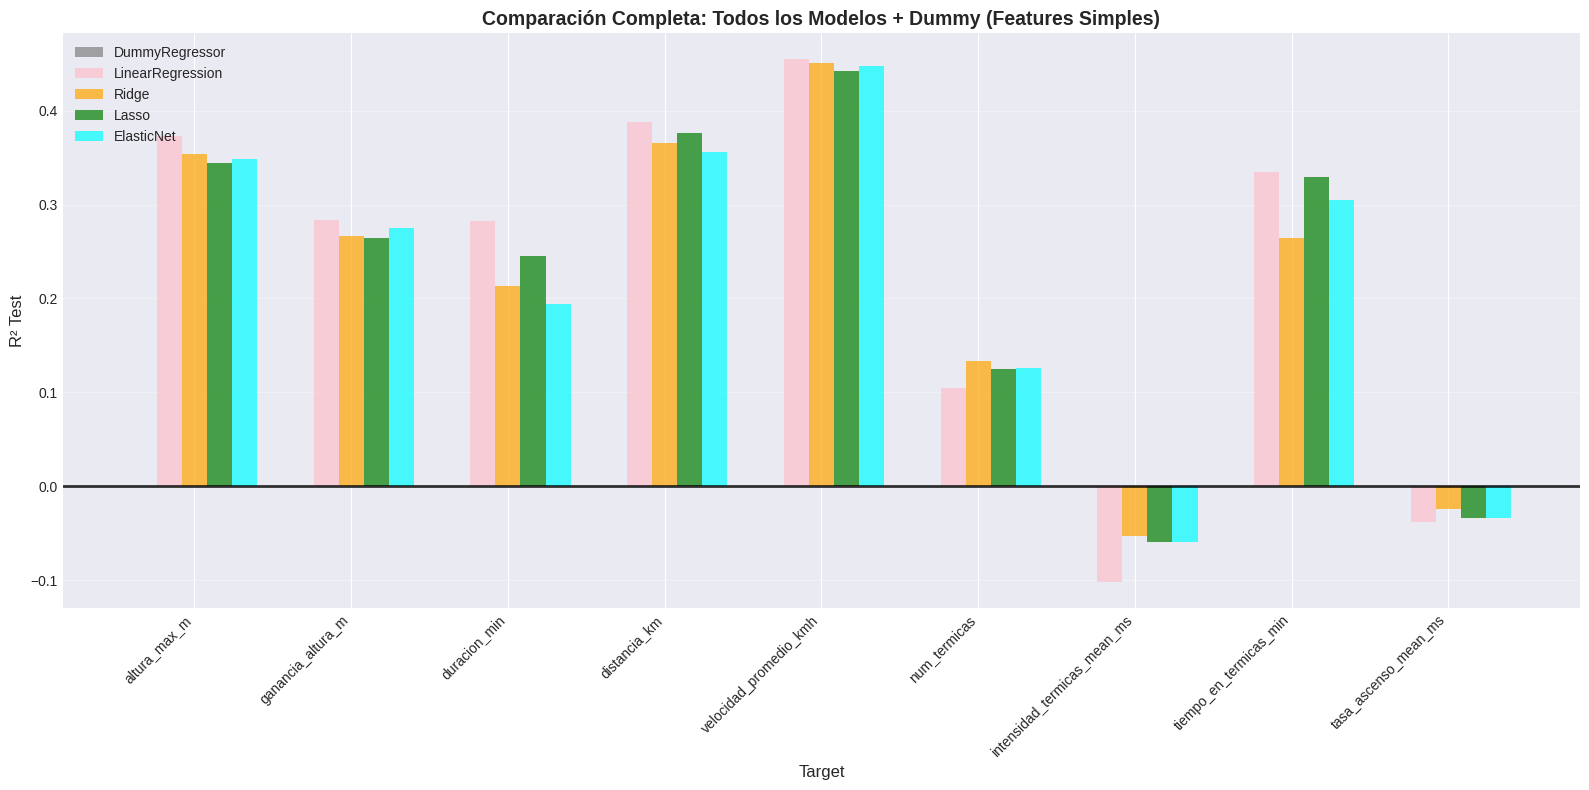

In [14]:
# Gráfico 1: Todos los modelos incluyendo Dummy (Features Simples)
fig, ax = plt.subplots(figsize=(16, 8))

# Combinar df_basico (Dummy) con df_simple
df_dummy_simple = df_basico[df_basico['modelo']=='DummyRegressor'][['target', 'R2', 'split']].copy()
df_dummy_simple = df_dummy_simple[df_dummy_simple['split']=='Test'].copy()
df_dummy_simple = df_dummy_simple.rename(columns={'R2': 'Test_R2'})
df_dummy_simple['modelo'] = 'DummyRegressor'

# Crear pivot incluyendo Dummy
df_todos_simple = pd.concat([
    df_dummy_simple[['target', 'modelo', 'Test_R2']],
    df_simple[['target', 'modelo', 'Test_R2']]
])
df_pivot = df_todos_simple.pivot(index='target', columns='modelo', values='Test_R2')

# CRÍTICO: Reordenar según targets_reg
df_pivot = df_pivot.reindex(targets_reg)

print("Verificando orden de targets:")
print(df_pivot.index.tolist())
print("\nR² de LinearRegression por target:")
print(df_pivot['LinearRegression'])

x = np.arange(len(targets_reg))
width = 0.16

modelos_lista_completa = ['DummyRegressor', 'LinearRegression', 'Ridge', 'Lasso', 'ElasticNet']
colors = ['gray', 'pink', 'orange', 'green', 'cyan']

for i, (modelo, color) in enumerate(zip(modelos_lista_completa, colors)):
    offset = (i - 2) * width
    valores = df_pivot[modelo].values
    
    bars = ax.bar(x + offset, valores, width, label=modelo, color=color, alpha=0.7)

ax.set_xlabel('Target', fontsize=12)
ax.set_ylabel('R² Test', fontsize=12)
ax.set_title('Comparación Completa: Todos los Modelos + Dummy (Features Simples)', 
             fontsize=14, fontweight='bold')
ax.set_xticks(x)
ax.set_xticklabels(targets_reg, rotation=45, ha='right')
ax.legend(fontsize=10, loc='upper left')
ax.axhline(y=0, color='black', linestyle='-', linewidth=2, alpha=0.8)
ax.grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.savefig('../data/processed/baseline_todos_simple.png', dpi=300, bbox_inches='tight')
plt.show()


Verificando orden de targets (features completas):
['altura_max_m', 'ganancia_altura_m', 'duracion_min', 'distancia_km', 'velocidad_promedio_kmh', 'num_termicas', 'intensidad_termicas_mean_ms', 'tiempo_en_termicas_min', 'tasa_ascenso_mean_ms']


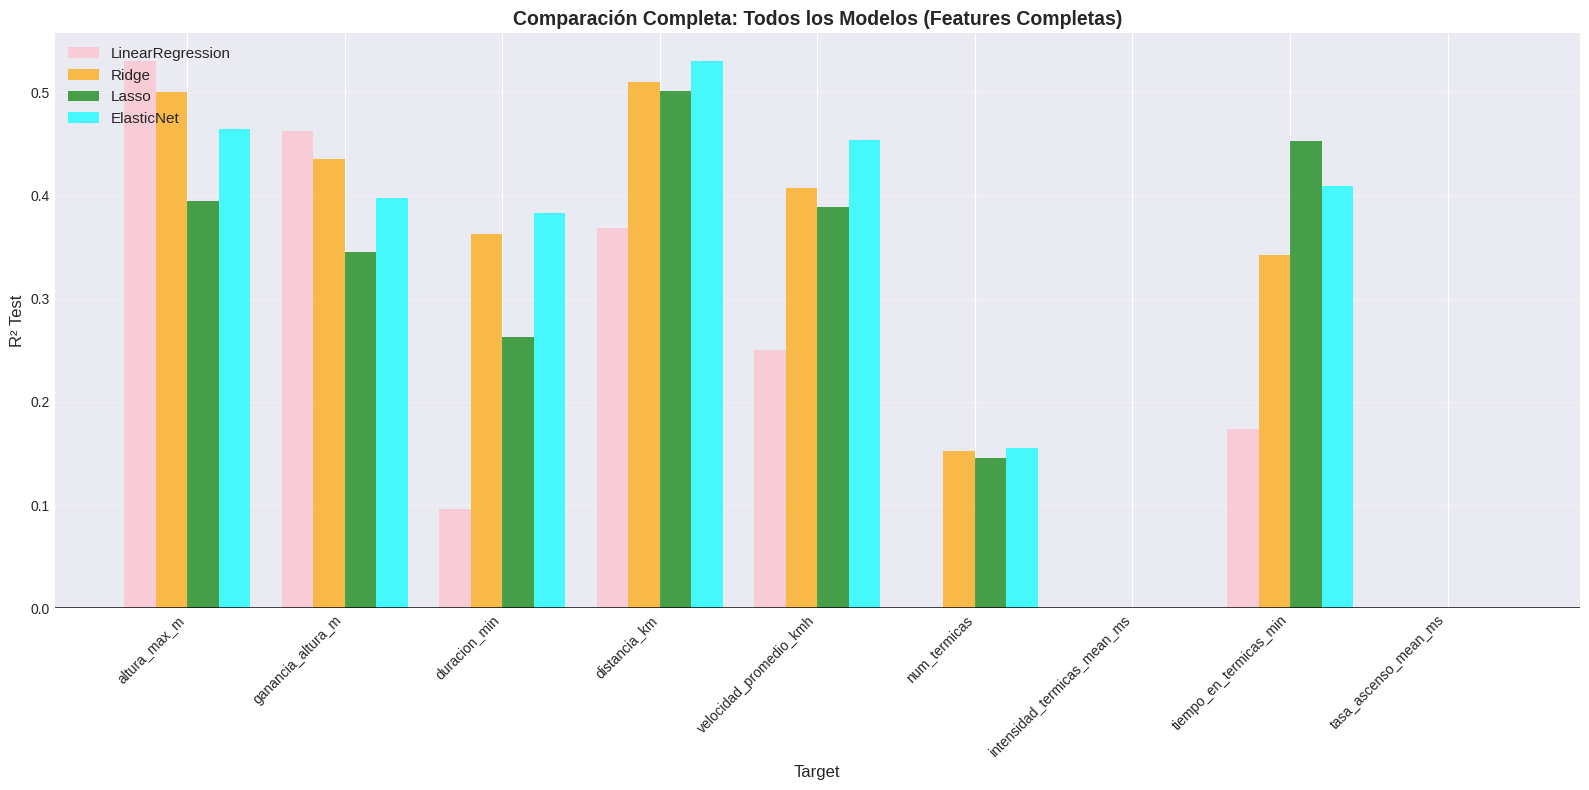

In [15]:
# Gráfico 1b: Todos los modelos (Features Completas)
fig, ax = plt.subplots(figsize=(16, 8))

df_pivot_full = df_full.pivot(index='target', columns='modelo', values='Test_R2')

# CRÍTICO: Reordenar según targets_reg
df_pivot_full = df_pivot_full.reindex(targets_reg)

print("\nVerificando orden de targets (features completas):")
print(df_pivot_full.index.tolist())

x = np.arange(len(targets_reg))
width = 0.2

modelos_lista = ['LinearRegression', 'Ridge', 'Lasso', 'ElasticNet']
colors = ['pink', 'orange', 'green', 'cyan']

for i, (modelo, color) in enumerate(zip(modelos_lista, colors)):
    offset = (i - 1.5) * width
    valores = df_pivot_full[modelo].values
    
    bars = ax.bar(x + offset, valores, width, label=modelo, color=color, alpha=0.7)
    

ax.set_xlabel('Target', fontsize=12)
ax.set_ylabel('R² Test', fontsize=12)
ax.set_title('Comparación Completa: Todos los Modelos (Features Completas)', 
             fontsize=14, fontweight='bold')
ax.set_xticks(x)
ax.set_xticklabels(targets_reg, rotation=45, ha='right')
ax.legend(fontsize=11, loc='upper left')
ax.axhline(y=0, color='black', linestyle='-', linewidth=2, alpha=0.8)
ax.grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.savefig('../data/processed/baseline_todos_full.png', dpi=300, bbox_inches='tight')
plt.show()

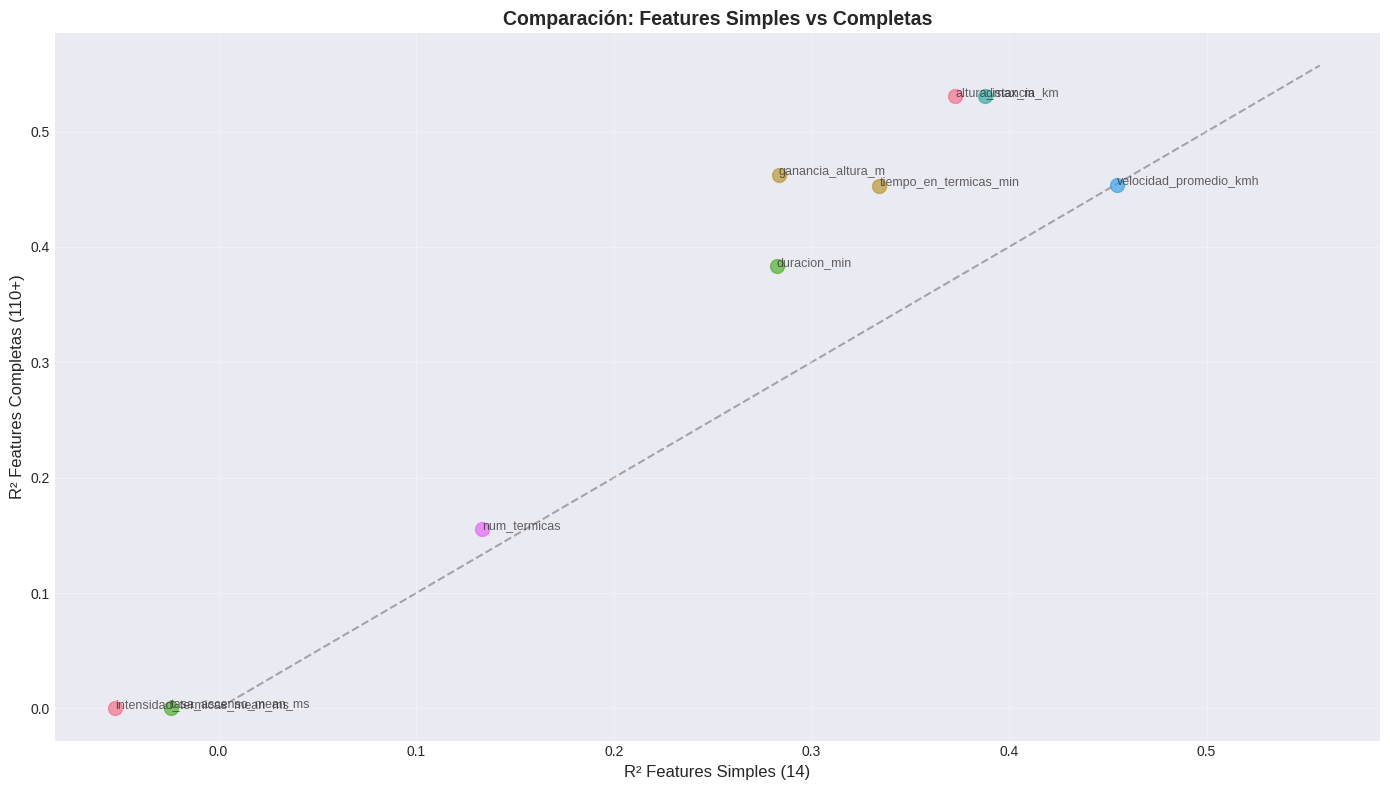

In [16]:
# Gráfico 2: Simple vs Full
fig, ax = plt.subplots(figsize=(14, 8))

for target in targets_reg:
    best_simple = df_simple[df_simple['target']==target]['Test_R2'].max()
    best_full = df_full[df_full['target']==target]['Test_R2'].max()
    
    ax.scatter(best_simple, best_full, s=100, alpha=0.7)
    ax.annotate(target, (best_simple, best_full), fontsize=9, alpha=0.7)

lims = [0, max(ax.get_xlim()[1], ax.get_ylim()[1])]
ax.plot(lims, lims, 'k--', alpha=0.3, zorder=0)

ax.set_xlabel('R² Features Simples (14)', fontsize=12)
ax.set_ylabel('R² Features Completas (110+)', fontsize=12)
ax.set_title('Comparación: Features Simples vs Completas', 
             fontsize=14, fontweight='bold')
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('../data/processed/baseline_simple_vs_full.png', dpi=300, bbox_inches='tight')
plt.show()

## 11. Recomendación Final

In [17]:
print("="*70)
print("RECOMENDACIÓN FINAL - BASELINE")
print("="*70)

mejor_config_simple = df_simple.groupby('modelo')['Test_R2'].mean().idxmax()
mejor_config_full = df_full.groupby('modelo')['Test_R2'].mean().idxmax()

r2_promedio_simple = df_simple[df_simple['modelo']==mejor_config_simple]['Test_R2'].mean()
r2_promedio_full = df_full[df_full['modelo']==mejor_config_full]['Test_R2'].mean()

print(f"\nMejor modelo con features SIMPLES:")
print(f"  Modelo: {mejor_config_simple}")
print(f"  R² promedio: {r2_promedio_simple:.4f}")
print(f"  Features: 14 promedios meteorológicos")

print(f"\nMejor modelo con features COMPLETAS:")
print(f"  Modelo: {mejor_config_full}")
print(f"  R² promedio: {r2_promedio_full:.4f}")
print(f"  Features: 110+ horarias")

print("\n" + "="*70)
print("CONCLUSIÓN:")
print("="*70)

if r2_promedio_simple > r2_promedio_full:
    print(f"\n✓ USAR: {mejor_config_simple} con features SIMPLES")
    print(f"\nRazones:")
    print(f"  1. Mejor R² promedio ({r2_promedio_simple:.4f} vs {r2_promedio_full:.4f})")
    print(f"  2. Ratio samples/features saludable (22:1)")
    print(f"  3. Menor riesgo de overfitting")
    print(f"  4. Más interpretable")
else:
    print(f"\n✓ USAR: {mejor_config_full} con features COMPLETAS")
    print(f"\nRazones:")
    print(f"  1. Mejor R² promedio ({r2_promedio_full:.4f} vs {r2_promedio_simple:.4f})")
    print(f"  2. Captura evolución temporal horaria")
    print(f"  3. Regularización controla overfitting")

print("\n" + "="*70)

# Top 5 targets
print("\nTop 5 Targets (Mejor configuración):")
top_config = df_full if r2_promedio_full > r2_promedio_simple else df_simple
top5 = top_config.groupby('target')['Test_R2'].max().nlargest(5)
for i, (target, r2) in enumerate(top5.items(), 1):
    print(f"  {i}. {target:30s}: R² = {r2:.4f}")

RECOMENDACIÓN FINAL - BASELINE

Mejor modelo con features SIMPLES:
  Modelo: LinearRegression
  R² promedio: 0.2312
  Features: 14 promedios meteorológicos

Mejor modelo con features COMPLETAS:
  Modelo: ElasticNet
  R² promedio: 0.3106
  Features: 110+ horarias

CONCLUSIÓN:

✓ USAR: ElasticNet con features COMPLETAS

Razones:
  1. Mejor R² promedio (0.3106 vs 0.2312)
  2. Captura evolución temporal horaria
  3. Regularización controla overfitting


Top 5 Targets (Mejor configuración):
  1. distancia_km                  : R² = 0.5307
  2. altura_max_m                  : R² = 0.5305
  3. ganancia_altura_m             : R² = 0.4623
  4. velocidad_promedio_kmh        : R² = 0.4537
  5. tiempo_en_termicas_min        : R² = 0.4529


## 12. Guardar Resultados

In [18]:
# Guardar resultados
df_basico.to_csv('../data/processed/baseline_basico.csv', index=False)
df_todos.to_csv('../data/processed/baseline_completo.csv', index=False)

print("\n" + "="*70)
print("ARCHIVOS GUARDADOS")
print("="*70)
print("  - data/processed/baseline_basico.csv")
print("  - data/processed/baseline_completo.csv")
print("  - data/processed/baseline_todos_simple.png")
print("  - data/processed/baseline_todos_full.png")
print("  - data/processed/baseline_simple_vs_full.png")
print("\n" + "="*70)
print("✓ BASELINE COMPLETO FINALIZADO")
print("  - Comparación exhaustiva: Linear, Ridge, Lasso, ElasticNet")
print("  - Features simples vs completas")
print("  - Normalización aplicada")
print("  - Tuning de hiperparámetros")
print("="*70)


ARCHIVOS GUARDADOS
  - data/processed/baseline_basico.csv
  - data/processed/baseline_completo.csv
  - data/processed/baseline_todos_simple.png
  - data/processed/baseline_todos_full.png
  - data/processed/baseline_simple_vs_full.png

✓ BASELINE COMPLETO FINALIZADO
  - Comparación exhaustiva: Linear, Ridge, Lasso, ElasticNet
  - Features simples vs completas
  - Normalización aplicada
  - Tuning de hiperparámetros
